# VDC Autoencoder

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
%matplotlib inline

## Prepare the dataset

In [2]:
IMG_SIZE = (256, 256)

In [3]:
data_folder = '/home/data_pj_flores/XImages'
images_list = [os.path.join(data_folder, x) for x in os.listdir(data_folder)]
print('Found {} images'.format(len(images_list)))

Found 29988 images


In [4]:
images_list[:10]

['/home/data_pj_flores/XImages/IMG_5633.jpg',
 '/home/data_pj_flores/XImages/IMG_23213.jpg',
 '/home/data_pj_flores/XImages/IMG_11038.jpg',
 '/home/data_pj_flores/XImages/IMG_97.jpg',
 '/home/data_pj_flores/XImages/IMG_11711.jpg',
 '/home/data_pj_flores/XImages/IMG_7542.jpg',
 '/home/data_pj_flores/XImages/IMG_808.jpg',
 '/home/data_pj_flores/XImages/IMG_3555.jpg',
 '/home/data_pj_flores/XImages/IMG_13085.jpg',
 '/home/data_pj_flores/XImages/IMG_1816.jpg']

In [5]:
train_images, test_images = train_test_split(images_list, test_size=0.2)
print('Train images: {}'.format(len(train_images)))
print('Test images: {}'.format(len(test_images)))

Train images: 23990
Test images: 5998


In [6]:
def map_image(image_path):
    rgb = tf.io.read_file(image_path)
    rgb = tf.image.decode_jpeg(rgb, channels=3)
    rgb = tf.image.resize(rgb, IMG_SIZE)
    rgb = tf.cast(rgb, dtype=tf.float32)
    rgb = rgb / 255.0
    return rgb, rgb

In [7]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tf.data.Dataset.from_tensor_slices(test_images).map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

## Define the model

In [8]:
def encoder(inputs, layer_filters, kernel_size, latent_dim):
    x = inputs
    for filters in layer_filters:
        x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    shape = tf.keras.backend.int_shape(x)
    x = tf.keras.layers.Flatten(name='output_encoder')(x)
    # x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # x = tf.keras.layers.Dense(latent_dim, name='output_encoder')(x)
    return x, shape


# def decoder(inputs, shape, channels):
#     x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(inputs)
#     x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
    
#     for filters in layer_filters[::-1]:
#         x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
#     return x


def decoder(inputs, layer_filters, shape, channels, latent_dim):
    # x = tf.keras.layers.Dense(shape[1] * shape[2] * shape[3])(inputs)
    # x = tf.keras.layers.Reshape((shape[1], shape[2], shape[3]))(x)
    x = tf.keras.layers.Reshape((int(latent_dim**0.5), int(latent_dim**0.5), 1))(inputs)
    
    for filters in layer_filters:
        x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
    return x


def convolutional_autoencoder(input_shape, encoder_filters, decoder_filters, kernel_size, latent_dim, channels):
    inputs = tf.keras.layers.Input(shape=input_shape)
    encoder_output, shape = encoder(inputs, encoder_filters, kernel_size, latent_dim)
    decoder_output = decoder(encoder_output, decoder_filters, shape, channels, latent_dim)
    autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    return autoencoder_model


input_shape = (*IMG_SIZE, 3)
kernel_size = 3
latent_dim = 1024
output_channels = 3
encoder_filters = [32, 64, 64, 64, 128, 128, 256]
decoder_filters = [32, 64, 32]

autoencoder_model = convolutional_autoencoder(input_shape, encoder_filters, decoder_filters, kernel_size, latent_dim, output_channels)
autoencoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256   

In [9]:
# def encoder(inputs, layer_filters, kernel_size, latent_dim):
#     x = inputs
#     for filters in layer_filters:
#         x = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     shape = tf.keras.backend.int_shape(x)
#     x = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same', name='output_encoder')(x)
#     encoder_visualization = tf.keras.layers.Conv2D(1, 3, activation='sigmoid', padding='same')(x)
#     return x, shape, encoder_visualization


# def decoder(inputs, shape, latent_dim, channels):
#     x = inputs
#     for filters in layer_filters[::-1]:
#         x = tf.keras.layers.Conv2DTranspose(filters=filters, kernel_size=kernel_size, strides=2, activation='relu', padding='same')(x)
#         x = tf.keras.layers.BatchNormalization()(x)

#     x = tf.keras.layers.Conv2DTranspose(filters=channels, kernel_size=kernel_size, activation='sigmoid', padding='same')(x)
#     return x


# def convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, channels):
#     inputs = tf.keras.layers.Input(shape=input_shape)
#     encoder_output, shape, encoder_visualization = encoder(inputs, layer_filters, kernel_size, latent_dim)
#     decoder_output = decoder(encoder_output, shape, latent_dim, channels)
    
#     encoder_model_viz = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
#     autoencoder_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
#     return autoencoder_model, encoder_model_viz


# input_shape = (*IMG_SIZE, 3)
# kernel_size = 3
# latent_dim = 256
# output_channels = 3
# layer_filters = [32, 64, 128]

# autoencoder_model, encoder_viz = convolutional_autoencoder(input_shape, layer_filters, kernel_size, latent_dim, output_channels)
# autoencoder_model.summary()

In [10]:
autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                            loss='mean_squared_error')

## Train the model

In [11]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)

In [12]:
train_steps = len(train_images) // BATCH_SIZE
valid_steps = len(test_images) // BATCH_SIZE

history = autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, 
                                validation_data=test_dataset, validation_steps=valid_steps, 
                                epochs=20, callbacks=[early_stopping, learning_rate_reduction])

Epoch 1/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0166 - val_loss: 0.0092 - lr: 0.0010
Epoch 2/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0080 - val_loss: 0.0117 - lr: 0.0010
Epoch 3/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0072 - val_loss: 0.0064 - lr: 0.0010
Epoch 4/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0073 - val_loss: 0.0070 - lr: 0.0010
Epoch 5/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0068 - val_loss: 0.0066 - lr: 0.0010
Epoch 6/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0064 - val_loss: 0.0059 - lr: 1.0000e-04
Epoch 7/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0063 - val_loss: 0.0058 - lr: 1.0000e-04
Epoch 8/20
749/749 [==============================] - 243s 324ms/step - loss: 0.0062 - val_loss: 0.0057 - lr: 1.0000e-04
Epoch 9/20
749/749 [==============================] 

## Get encoder and decoder models

In [25]:
encoder_model = tf.keras.Model(inputs=autoencoder_model.input, 
                               outputs=autoencoder_model.get_layer('output_encoder').output)
encoder_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 64)        256 

In [26]:
# encoder_viz.summary()

## Display sample

In [27]:
def display_one_row(disp_images, offset, encoded=False):
    for idx, test_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + idx + 1)
        plt.xticks([])
        plt.yticks([])
        if encoded:
            plt.imshow(test_image, cmap='gray')
        else:
            plt.imshow(test_image)


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
    plt.figure(figsize=(20, 5))
    display_one_row(disp_input_images, 0)
    display_one_row(disp_encoded, 10, encoded=True)
    display_one_row(disp_predicted, 20)

In [28]:
test_data = np.array(next(iter(test_dataset))[0])
idxs = np.random.randint(BATCH_SIZE, size=10)
output_samples = test_data[idxs]
print(output_samples.shape)

(10, 256, 256, 3)


In [39]:
predicted = autoencoder_model.predict(output_samples)
encoded = encoder_model.predict(output_samples)
# encoded_viz = encoder_viz.predict(output_samples)
encoded_viz = np.array(encoded).reshape((-1, int(latent_dim**0.5), int(latent_dim**0.5)))

In [40]:
print(predicted.shape)
print(encoded.shape)
print(encoded_viz.shape)

(10, 256, 256, 3)
(10, 1024)
(10, 32, 32)


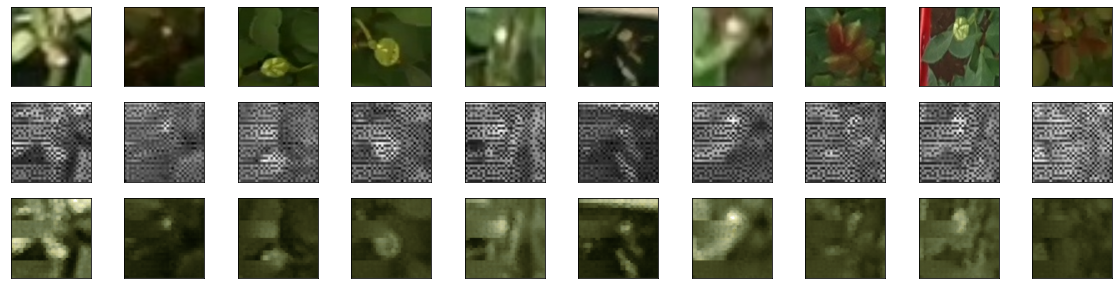

In [47]:
display_results(np.array(output_samples), encoded_viz, np.array(predicted))

## Save models

In [20]:
autoencoder_model.save('models/train_1/autoencoder_model.h5')
encoder_model.save('models/train_1/encoder_model.h5')

## Reload models

In [48]:
autoencoder_model_2 = tf.keras.models.load_model('models/train_1/autoencoder_model.h5')
encoder_model_2 = tf.keras.models.load_model('models/train_1/encoder_model.h5')

In [49]:
predicted = autoencoder_model_2.predict(output_samples)
encoded = encoder_model_2.predict(output_samples)
encoded_viz = np.array(encoded).reshape((-1, int(latent_dim**0.5), int(latent_dim**0.5)))

In [50]:
print(predicted.shape)
print(encoded.shape)
print(encoded_viz.shape)

(10, 256, 256, 3)
(10, 1024)
(10, 32, 32)


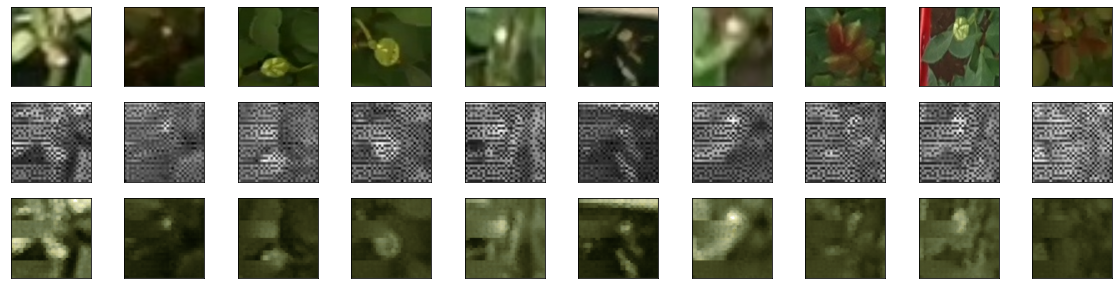

In [51]:
display_results(np.array(output_samples), encoded_viz, np.array(predicted))

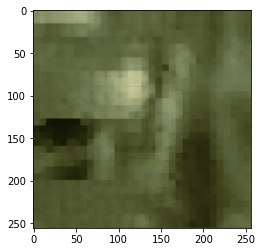

In [53]:
plt.imshow(np.array(predicted)[4])